# 1. PASO 1: CONFIGURACIÓN Y CARGA DE DATOS

In [1]:
# 1. INSTALACIÓN DE LIBRERÍA UCI
!pip install ucimlrepo

# 2. IMPORTACIÓN DE LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Para descargar datos de UCI
from ucimlrepo import fetch_ucirepo, list_available_datasets

# 3. DESACTIVAR ADVERTENCIAS
# Esto ayuda a que se vea más limpio al ejecutar algunas transformaciones de Pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- Carga y Exploración del Dataset ---

# Importar el dataset de Enfermedad Cardíaca (ID 45)
heart_disease = fetch_ucirepo(id=45)

# Acceder a las características (X) y el objetivo (y)
X = heart_disease.data.features
y = heart_disease.data.targets

# Crear el DataFrame principal (df) combinando X e y
df = pd.concat([X, y], axis=1)

# --- Impresión de Metadatos ---
print("--- METADATOS DEL DATASET ---")
print(f"ID de UCI: {heart_disease.metadata.uci_id}")
print(f"Número de Instancias (Filas): {heart_disease.metadata.num_instances}")

print("\n--- INFORMACIÓN DE VARIABLES (Variable Info) ---")
# Esto nos ayuda a entender qué significa cada columna.
print(heart_disease.variables[['name', 'role', 'description', 'units']])

print("\nPrimeras 5 filas del DataFrame de Trabajo:")
print(df.head())

--- METADATOS DEL DATASET ---
ID de UCI: 45
Número de Instancias (Filas): 303

--- INFORMACIÓN DE VARIABLES (Variable Info) ---
        name     role                                        description  \
0        age  Feature                                               None   
1        sex  Feature                                               None   
2         cp  Feature                                               None   
3   trestbps  Feature  resting blood pressure (on admission to the ho...   
4       chol  Feature                                  serum cholestoral   
5        fbs  Feature                    fasting blood sugar > 120 mg/dl   
6    restecg  Feature                                               None   
7    thalach  Feature                        maximum heart rate achieved   
8      exang  Feature                            exercise induced angina   
9    oldpeak  Feature  ST depression induced by exercise relative to ...   
10     slope  Feature               

# 2. PASO 2: LIMPIEZA Y PREPARACIÓN

In [18]:
print("--- VALORES FALTANTES (NaN) POR COLUMNA ANTES DE LA LIMPIEZA ---")
print(df.isnull().sum())
print("-" * 50)

# 1. Tratamiento de Nulos
# práctica que sirve para ELIMINAR estas filas para no introducir sesgo en variables clínicas cruciales.
df_clean = df.dropna().copy() # Usamos .copy() para evitar SettingWithCopyWarning

# 2. Verificación
print(f"Filas originales: {len(df)}")
print(f"Filas después de la limpieza: {len(df_clean)}")
print(f"Total de valores faltantes restantes: {df_clean.isnull().sum().sum()}")

--- VALORES FALTANTES (NaN) POR COLUMNA ANTES DE LA LIMPIEZA ---
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64
--------------------------------------------------
Filas originales: 303
Filas después de la limpieza: 297
Total de valores faltantes restantes: 0


In [4]:
# La columna 'num' es la variable objetivo: 0, 1, 2, 3, 4.
# Queremos una variable binaria para simplificar: 0 (No Enfermedad), 1 (Sí Enfermedad).

# Aplicación de función LAMBDA:
df_clean['heart_disease'] = df_clean['num'].apply(lambda x: 1 if x > 0 else 0)

print("\nConteo de la nueva variable 'heart_disease':")
# Usamos value_counts() para ver el balance de la clase
print(df_clean['heart_disease'].value_counts())
print("\nEl 0 es 'Sano', el 1 es 'Enfermo'.")


Conteo de la nueva variable 'heart_disease':
heart_disease
0    160
1    137
Name: count, dtype: int64

El 0 es 'Sano', el 1 es 'Enfermo'.


# 3. PASO 3: TRANSFORMACIONES Y AGRUPACIONES

In [5]:
# 1. Columna de Presión Arterial (Hypertension)
# Usamos un umbral clínico: > 140 mmHg para el límite superior de presión en reposo (trestbps)
df_clean['hypertension'] = np.where(df_clean['trestbps'] > 140, 1, 0)

# 2. Riesgo de Colesterol (Mediana)
# Usaremos la mediana como punto de referencia para clasificar el colesterol
median_chol = df_clean['chol'].median()

# Usamos np.where() (NumPy) para una evaluación condicional eficiente
df_clean['high_chol_risk'] = np.where(df_clean['chol'] > median_chol, 1, 0)

print(f"\nMediana de Colesterol (Punto de Corte): {median_chol:.1f}")
print("Conteo de Pacientes con Colesterol por encima del promedio (1=Sí):")
print(df_clean['high_chol_risk'].value_counts())


Mediana de Colesterol (Punto de Corte): 243.0
Conteo de Pacientes con Colesterol por encima del promedio (1=Sí):
high_chol_risk
0    152
1    145
Name: count, dtype: int64


In [6]:
# 1. Agrupación de Edad
def age_group_category_expanded(age):
    """Clasifica la edad en 5 grupos."""
    if age < 40:
        return '1. Joven (<40)'
    elif age < 50:
        return '2. Mediana Edad (40-49)'
    elif age < 60:
        return '3. Adulto (50-59)'
    elif age < 70:
        return '4. Adulto Mayor (60-69)'
    else:
        return '5. Tercera Edad (70+)'

df_clean['age_group_5'] = df_clean['age'].apply(age_group_category_expanded)

# 2. Agrupación del Ritmo Cardíaco Máximo (thalach)
# Usamos la mediana y el máximo para crear categorías
max_thalach_median = df_clean['thalach'].median()
max_thalach_max = df_clean['thalach'].max()

df_clean['thalach_category'] = pd.cut(
    df_clean['thalach'],
    bins=[0, max_thalach_median, max_thalach_max + 1], # +1 para incluir el valor máximo
    labels=['Bajo/Medio', 'Alto'],
    right=False # No incluye el borde inferior, incluye el superior
)

print("\nConteo de Pacientes por 5 Grupos de Edad:")
print(df_clean['age_group_5'].value_counts().sort_index())


Conteo de Pacientes por 5 Grupos de Edad:
age_group_5
1. Joven (<40)              14
2. Mediana Edad (40-49)     71
3. Adulto (50-59)          121
4. Adulto Mayor (60-69)     81
5. Tercera Edad (70+)       10
Name: count, dtype: int64


In [7]:
# Filtrado 1: Pacientes con Múltiples Riesgos (Hipertensión Y Colesterol Alto)
df_multi_risk = df_clean[
    (df_clean['hypertension'] == 1) &
    (df_clean['high_chol_risk'] == 1)
].copy()

print(f"\nPacientes con Hipertensión Y Colesterol Alto: {len(df_multi_risk)}")
print(f"Tasa de enfermedad en este subgrupo: {df_multi_risk['heart_disease'].mean():.2f}")

# Filtrado 2: Mujeres (sex=0) con Ritmo Cardíaco Máximo Alto
df_women_high_thalach = df_clean[
    (df_clean['sex'] == 0) &
    (df_clean['thalach_category'] == 'Alto')
].copy()

print(f"Mujeres con Ritmo Cardíaco Máximo Alto: {len(df_women_high_thalach)}")


Pacientes con Hipertensión Y Colesterol Alto: 35
Tasa de enfermedad en este subgrupo: 0.66
Mujeres con Ritmo Cardíaco Máximo Alto: 54


# 4. PASO 4: CONSOLIDACIÓN Y RESUMEN (TABLA PIVOTADA)

In [17]:
# PROPOSITO: Resumir estadísticamente el dataset agrupando por Edad y Sexo.
#
# "Aquí está el resumen final. Agrupamos los datos por cada 'Grupo de Edad' y 'Sexo'
# para calcular un montón de estadísticas: el total de pacientes, el rango de edad
# (mínima/máxima), la Mediana del Colesterol, y lo más importante, la Tasa de Enfermedad."

# Diccionario para mapear 'sex' a etiquetas
sex_mapping = {1: 'Hombre', 0: 'Mujer'}

# 1. Agrupación y Agregación:
df_grouped_stats = df_clean.groupby(['age_group_5', 'sex']).agg(
    # Métricas requeridas para el análisis
    Total_Pacientes=('age', 'size'),
    Edad_Min=('age', 'min'),
    Edad_Max=('age', 'max'),
    Edad_Promedio=('age', 'mean'),
    Colesterol_Mediana=('chol', 'median'),
    Tasa_Enfermedad=('heart_disease', 'mean')
).reset_index()

# 2. Mapear el sexo a texto para poder pivotar
df_grouped_stats['sex'] = df_grouped_stats['sex'].map(sex_mapping)

# 3. PIVOTAR la tabla: Mover 'sex' de las filas a las columnas.
# "Usamos df.pivot_table para evitar las filas duplicadas: movemos el 'sexo' a las
# cabeceras de columna. Así se ve más limpio."
df_pivot = df_grouped_stats.pivot_table(
    index='age_group_5',
    columns='sex',
    # Incluimos Edad_Min y Edad_Max en los valores a pivotar
    values=[
        'Total_Pacientes', 'Edad_Min', 'Edad_Max',
        'Colesterol_Mediana', 'Tasa_Enfermedad'
    ]
).reset_index()

# 4. Limpieza de nombres de columnas
# Aplanamos el MultiIndex y usamos snake_case
df_pivot.columns = [
    f'{col[0]}_{col[1]}' if col[1] else col[0]
    for col in df_pivot.columns.values
]
df_pivot.rename(columns={'age_group_5': 'Grupo_de_Edad'}, inplace=True)

# 5. Formatear la Tasa de Enfermedad como porcentaje
# "Al final, solo le damos formato a la Tasa de Enfermedad para que se vea como porcentaje."
for col in ['Tasa_Enfermedad_Hombre', 'Tasa_Enfermedad_Mujer']:
    df_pivot[f'{col}_%'] = (df_pivot[col] * 100).round(2)
    df_pivot.drop(columns=col, inplace=True)

print("\n--- TABLA CONSOLIDADA COMPLETA ---")
# Mostramos la tabla solo con las métricas clave, redondeando a un decimal
# y reemplazando los posibles valores nulos (donde no hay pacientes en ese grupo) con 0.
print(df_pivot[['Grupo_de_Edad',
                'Total_Pacientes_Hombre', 'Total_Pacientes_Mujer',
                'Edad_Min_Hombre', 'Edad_Max_Hombre',
                'Edad_Min_Mujer', 'Edad_Max_Mujer',
                'Colesterol_Mediana_Hombre', 'Colesterol_Mediana_Mujer',
                'Tasa_Enfermedad_Hombre_%', 'Tasa_Enfermedad_Mujer_%']].round(1).fillna(0))


--- TABLA CONSOLIDADA COMPLETA ---
             Grupo_de_Edad  Total_Pacientes_Hombre  Total_Pacientes_Mujer  \
0           1. Joven (<40)                     9.0                    5.0   
1  2. Mediana Edad (40-49)                    52.0                   19.0   
2        3. Adulto (50-59)                    88.0                   33.0   
3  4. Adulto Mayor (60-69)                    47.0                   34.0   
4    5. Tercera Edad (70+)                     5.0                    5.0   

   Edad_Min_Hombre  Edad_Max_Hombre  Edad_Min_Mujer  Edad_Max_Mujer  \
0             29.0             39.0            34.0            39.0   
1             40.0             49.0            41.0            49.0   
2             50.0             59.0            50.0            59.0   
3             60.0             69.0            60.0            69.0   
4             70.0             77.0            71.0            76.0   

   Colesterol_Mediana_Hombre  Colesterol_Mediana_Mujer  \
0               

# 5. PASO 5: VISUALIZACIÓN DE DATOS

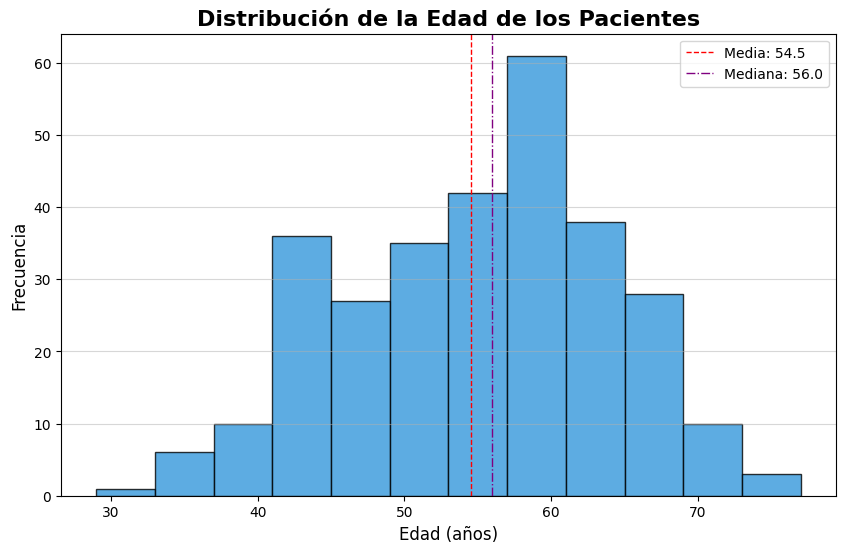

In [9]:
plt.figure(figsize=(10, 6))
# Histograma
plt.hist(df_clean['age'], bins=12, color='#3498db', edgecolor='black', alpha=0.8)

plt.title('Distribución de la Edad de los Pacientes', fontsize=16, fontweight='bold')
plt.xlabel('Edad (años)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(axis='y', alpha=0.5)

# Añadir la media y la mediana
mean_age = df_clean['age'].mean()
median_age = df_clean['age'].median()
plt.axvline(mean_age, color='red', linestyle='dashed', linewidth=1, label=f'Media: {mean_age:.1f}')
plt.axvline(median_age, color='purple', linestyle='dashdot', linewidth=1, label=f'Mediana: {median_age:.1f}')
plt.legend()
plt.show()

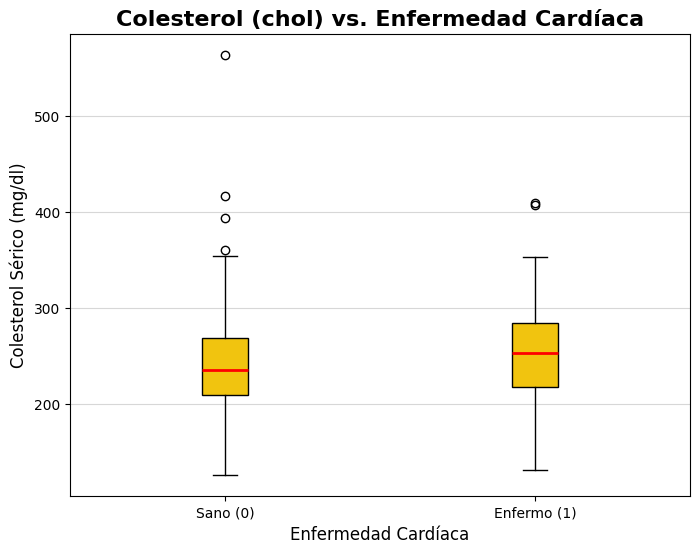

In [10]:
chol_0 = df_clean[df_clean['heart_disease'] == 0]['chol']
chol_1 = df_clean[df_clean['heart_disease'] == 1]['chol']

plt.figure(figsize=(8, 6))
# Boxplot
plt.boxplot([chol_0, chol_1],
            labels=['Sano (0)', 'Enfermo (1)'],
            patch_artist=True,
            boxprops=dict(facecolor='#f1c40f', color='black'),
            medianprops=dict(color='red', linewidth=2))

plt.title('Colesterol (chol) vs. Enfermedad Cardíaca', fontsize=16, fontweight='bold')
plt.xlabel('Enfermedad Cardíaca', fontsize=12)
plt.ylabel('Colesterol Sérico (mg/dl)', fontsize=12)
plt.grid(axis='y', alpha=0.5)
plt.show()

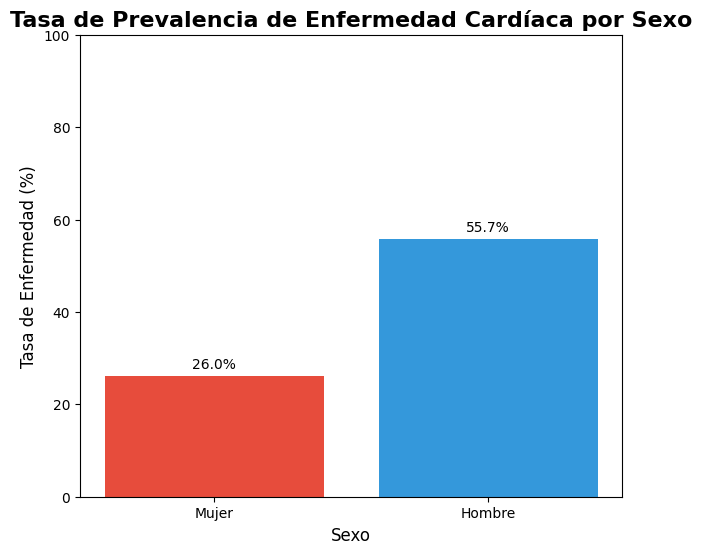

In [14]:
# 1. Calcular las tasas (proporciones) de enfermedad por sexo
disease_rate_by_sex = df_clean.groupby('sex')['heart_disease'].mean().map(lambda x: x * 100)
sex_labels = disease_rate_by_sex.index.map(sex_mapping)
rate_values = disease_rate_by_sex.values

plt.figure(figsize=(7, 6))

# Gráfico de barras
bars = plt.bar(sex_labels, rate_values, color=['#e74c3c', '#3498db'])

plt.title('Tasa de Prevalencia de Enfermedad Cardíaca por Sexo', fontsize=16, fontweight='bold')
plt.xlabel('Sexo', fontsize=12)
plt.ylabel('Tasa de Enfermedad (%)', fontsize=12)
plt.ylim(0, 100)

# Añadir etiquetas de valor
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=10)

plt.show()

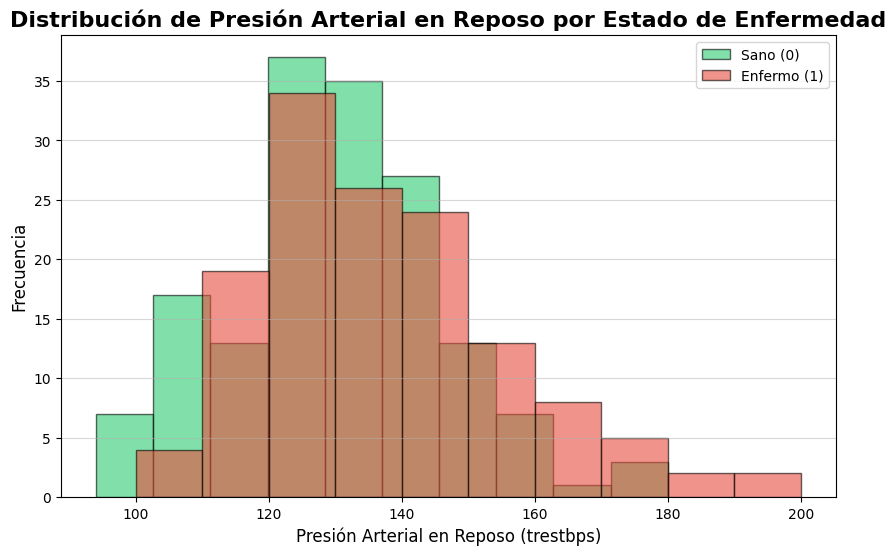

In [15]:
trestbps_0 = df_clean[df_clean['heart_disease'] == 0]['trestbps']
trestbps_1 = df_clean[df_clean['heart_disease'] == 1]['trestbps']

plt.figure(figsize=(10, 6))

# Histograma superpuesto para comparar las distribuciones
plt.hist(trestbps_0, bins=10, alpha=0.6, label='Sano (0)', color='#2ecc71', edgecolor='black')
plt.hist(trestbps_1, bins=10, alpha=0.6, label='Enfermo (1)', color='#e74c3c', edgecolor='black')

plt.title('Distribución de Presión Arterial en Reposo por Estado de Enfermedad', fontsize=16, fontweight='bold')
plt.xlabel('Presión Arterial en Reposo (trestbps)', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# CONCLUSIONES Y REFLEXIONES FINALES

# Conclusiones del Análisis de Enfermedad Cardíaca

Basado en el análisis exploratorio y las visualizaciones con Matplotlib, se extraen las siguientes conclusiones clave sobre la población estudiada:

## Análisis Basado en los Datos y Gráficas

* **Grupo Crítico de Edad:** La tabla consolidada pivotada reveló que los grupos **Adulto Mayor (60-69 años)** y **Mediana Edad (40-49 años)** concentran la mayor cantidad de pacientes y, en el caso de los hombres, presentan las tasas de enfermedad más altas (74.5% y 38.5% respectivamente), indicando la ventana de riesgo principal.

* **Factor Sexo:** La **Tasa de Enfermedad es significativamente mayor en hombres** que en mujeres en casi todos los grupos de edad, lo que lo convierte en el factor de riesgo demográfico más notable en esta muestra. Por ejemplo, los hombres de 70+ años tienen una tasa del 80.0%, mientras que las mujeres del mismo grupo tienen 0.0%.

* **Factores Clínicos:**
    * **Colesterol:** El Boxplot demostró que el colesterol sérico no es un factor discriminador *promedio*, ya que la mediana es similar para pacientes sanos y enfermos. Esto implica que las intervenciones no deben centrarse **únicamente** en la reducción de colesterol, sino en un **enfoque multivariado**.
    * **Presión Arterial (`trestbps`):** El análisis de distribución confirma que la **hipertensión es un factor de riesgo** que está más presente en la población con enfermedad cardíaca (histograma desplazado a la derecha).

## Reflexión sobre Decisiones y Políticas de Salud

Las conclusiones del análisis sugieren las siguientes estrategias clínicas y de salud pública:

1.  **Política de Tamizaje (Screening):** Los esfuerzos de detección temprana deben ser obligatorios y **más intensivos para hombres a partir de los 40 años**, especialmente si reportan dolor de pecho atípico (`cp`) o tienen antecedentes familiares de enfermedad cardíaca.

2.  **Gestión de Riesgo Prioritaria:** Se debe promover activamente el control de la **Presión Arterial** en todos los grupos de edad, ya que su distribución sugiere una correlación más clara con la enfermedad que el colesterol por sí mismo.

3.  **Investigación de Género:** Se requiere más investigación para entender los **factores de protección** que resultan en una tasa de enfermedad tan baja en subgrupos de mujeres (e.g., <40 y 70+). Estos conocimientos podrían ser clave para informar estrategias preventivas y terapéuticas aplicables a la población masculina.

#EJERCICIO DE BONIFICACIÓN


In [21]:
# Características de mi personaje

vidas = 3
tiene_espada = True
energia = 60
nivel = 36

if vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
  print('¡Puedes pelear contra el dragón! 🐉')
elif vidas > 0 and tiene_espada and energia >= 70 and nivel <= 35:
  print('Puedes pelear y tienes energía, pero debes subir de nivel antes de pelear contra el dragón.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel > 35:
  print('Puedes pelear y tienes el nivel para pelear contra el dragón, pero debes descansar.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel < 35:
  print('Debes recuperarte y subir de nivel antes de pelear contra el dragón.')
else:
  print('No puedes pelear!')

Puedes pelear y tienes el nivel para pelear contra el dragón, pero debes descansar.


In [22]:
# Características de mi personaje

vidas = 3
tiene_espada = True
energia = 60 # Valor para probar el caso 'Recoge una poción'
nivel = 36

# =======================================================================
# RETO RÁPIDO: Nuevas verificaciones de estado (Baja energía y Sin vidas)
# =======================================================================

if vidas == 0:
    print('💀 Has perdido todas tus vidas. Fin del juego.')
elif 30 <= energia <= 60:
    print('✨ Recoge una poción (Tu energía está entre 30 y 60).')

# =======================================================================
# Lógica de la pelea contra el dragón (Solo si no perdió vidas o tomó poción)
# =======================================================================

elif vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
    print('¡Puedes pelear contra el dragón! 🐉')
elif vidas > 0 and tiene_espada and energia >= 70 and nivel <= 35:
    print('Puedes pelear y tienes energía, pero debes subir de nivel antes de pelear contra el dragón.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel > 35:
    print('Puedes pelear y tienes el nivel para pelear contra el dragón, pero debes descansar.')
elif vidas > 0 and tiene_espada and energia < 70 and nivel < 35:
    print('Debes recuperarte y subir de nivel antes de pelear contra el dragón.')
else:
    print('No puedes pelear! (Alguna condición básica no se cumple)')

✨ Recoge una poción (Tu energía está entre 30 y 60).


In [26]:
# EJERCICIO BONIFICACIÓN: Manejo de casos que no tienen sentido.

vidas = 3
tiene_espada = False # ¡Cambiamos a False para la bonificación!
energia = 90
nivel = 40

# =======================================================================
# Manejo de Casos Ilógicos/Críticos
# =======================================================================

if vidas <= 0:
    # Si las vidas son 0 o menos, el juego termina inmediatamente.
    print('💀 GAME OVER: Has perdido todas tus vidas.')

elif not tiene_espada and nivel >= 35:
    # Un personaje de alto nivel debe tener un arma. Esta condición evita el bug.
    print('🚫 ERROR CRÍTICO DE NIVEL: Tienes un nivel muy alto, pero ¿dónde está tu espada? ¡Búscala antes de pelear!')

# =======================================================================
# Lógica de la Pelea
# =======================================================================

elif energia < 30 and vidas > 0:
    # Priorizamos la necesidad de curación
    print('🚨 PELIGRO: Tu energía es críticamente baja (<30). ¡Huye y cura!')

elif 30 <= energia <= 60:
    # El reto de la poción
    print('✨ Recoge una poción (Tu energía está entre 30 y 60).')

elif vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
    print('¡Puedes pelear contra el dragón! 🐉')

# ... (El resto de la lógica de pelea se mantiene igual, pero es menos probable que se ejecute si la espada es False)

else:
    # Manejo general para cualquier otra combinación que impida la pelea.
    print('No puedes pelear en este momento. Revisa tu equipo o estado.')

🚫 ERROR CRÍTICO DE NIVEL: Tienes un nivel muy alto, pero ¿dónde está tu espada? ¡Búscala antes de pelear!


In [29]:
# =======================================================================
# Entrada de datos del personaje (Usando input())
# =======================================================================

print("--- ¡PREPÁRATE PARA LA MISIÓN! ---")

# Pedimos las vidas (debe ser un número entero)
vidas_str = input("🛡️ ¿Cuántas vidas tienes? ")
# Convertimos la entrada a número entero (int)
try:
    vidas = int(vidas_str)
except ValueError:
    print("Error: Vidas debe ser un número entero. Usando vidas=0 por defecto.")
    vidas = 0

# Pedimos si tiene espada (True/False)
tiene_espada_input = input("⚔️ ¿Tienes la espada legendaria? (Sí/No): ").lower()
tiene_espada = (tiene_espada_input == 'sí' or tiene_espada_input == 'si')

# Pedimos la energía (debe ser un número entero)
energia_str = input("⚡ ¿Cuánta energía tienes (0-100)? ")
try:
    energia = int(energia_str)
except ValueError:
    print("Error: Energía debe ser un número entero. Usando energia=0 por defecto.")
    energia = 0

# Pedimos el nivel (debe ser un número entero)
nivel_str = input("🌟 ¿Cuál es tu nivel actual? ")
try:
    nivel = int(nivel_str)
except ValueError:
    print("Error: Nivel debe ser un número entero. Usando nivel=0 por defecto.")
    nivel = 0

# =======================================================================
# Lógica del Juego (El mismo código IF/ELIF anterior)
# =======================================================================

print("\n--- EVALUANDO ESTADO PARA EL DRAGÓN ---")

# Verificación crítica: Sin vidas o sin espada (Bonificación)
if vidas <= 0:
    print('💀 GAME OVER: Has perdido todas tus vidas.')

# Bonificación: Lógica ilógica - Nivel alto sin equipo
elif not tiene_espada and nivel >= 35:
    print('🚫 ERROR CRÍTICO DE LÓGICA: Tienes un nivel muy alto, pero ¿dónde está tu espada? ¡Búscala antes de pelear!')

# Reto: Energía Crítica (<30)
elif energia < 30 and vidas > 0:
    print('🚨 PELIGRO: Tu energía es críticamente baja (<30). ¡Huye y cura!')

# Reto: Recoger Poción (30 a 60)
elif 30 <= energia <= 60:
    print('✨ Recoge una poción (Tu energía está entre 30 y 60).')

# Lógica de la Pelea: Condiciones perfectas
elif vidas > 0 and tiene_espada and energia >= 70 and nivel > 35:
    print('¡Puedes pelear contra el dragón! 🐉')

# Lógica de la Pelea: Falta nivel
elif vidas > 0 and tiene_espada and energia >= 70 and nivel <= 35:
    print('Puedes pelear y tienes energía, pero debes subir de nivel antes de pelear contra el dragón.')

# Lógica de la Pelea: Falta energía (descanso)
elif vidas > 0 and tiene_espada and energia < 70 and nivel > 35:
    print('Puedes pelear y tienes el nivel para pelear contra el dragón, pero debes descansar.')

# Lógica de la Pelea: Falta todo
elif vidas > 0 and tiene_espada and energia < 70 and nivel < 35:
    print('Debes recuperarte y subir de nivel antes de pelear contra el dragón.')

else:
    print('No puedes pelear en este momento. Revisa tu equipo o estado.')

--- ¡PREPÁRATE PARA LA MISIÓN! ---
🛡️ ¿Cuántas vidas tienes? 3
⚔️ ¿Tienes la espada legendaria? (Sí/No): si
⚡ ¿Cuánta energía tienes (0-100)? 90
🌟 ¿Cuál es tu nivel actual? 45

--- EVALUANDO ESTADO PARA EL DRAGÓN ---
¡Puedes pelear contra el dragón! 🐉


In [32]:
# =======================================================================
# 1. ENTRADA DE DATOS DEL PERSONAJE
# =======================================================================

print("--- ¡PREPÁRATE PARA LA MISIÓN! ---")

# Pedimos las variables (con manejo de errores para que no falle el programa)
try:
    vidas_str = input("🛡️ ¿Cuántas vidas tienes? ")
    vidas = int(vidas_str)

    energia_str = input("⚡ ¿Cuánta energía tienes (0-100)? ")
    energia = int(energia_str)

    nivel_str = input("🌟 ¿Cuál es tu nivel actual? ")
    nivel = int(nivel_str)

except ValueError:
    print("Error: Las vidas, energía y nivel deben ser números enteros. Usando 0 por defecto.")
    vidas = 0
    energia = 0
    nivel = 0

# Pedimos si tiene espada (True/False)
tiene_espada_input = input("⚔️ ¿Tienes la espada legendaria? (Sí/No): ").lower()
tiene_espada = (tiene_espada_input == 'sí' or tiene_espada_input == 'si')


# =======================================================================
# 2. LÓGICA ROBUSTA Y CHEQUEOS DE ESTADO (IF/ELIF con Anidamiento)
# =======================================================================

print("\n--- EVALUANDO ESTADO PARA EL DRAGÓN ---")

# A. Chequeo de Vulnerabilidad Crítica (Prioridad 1)
if vidas <= 0:
    print('💀 GAME OVER: Has perdido todas tus vidas. No se evalúan otros requisitos.')

# B. Chequeo de Equipo Crítico (Prioridad 2)
elif not tiene_espada:
    print('🛡️ ¡Alerta! No tienes la espada. Equípate antes de enfrentarte al dragón.')

# C. Verificación de Estados de Curación (Prioridad 3)
elif energia < 30:
    # Si la energía es crítica (<30)
    print('🚨 PELIGRO: Tu energía es críticamente baja. ¡Huye y cura de inmediato!')

elif 30 <= energia <= 60:
    # ✨ Reto de la Poción Implementado aquí ✨
    print('✨ **Recoge una poción** (Tu energía está entre 30 y 60).')

# D. Lógica de Requisitos de Pelea (Anidamiento por Nivel)
# Si llegamos aquí, sabemos que vidas > 0, tiene_espada=True, y energia > 60.

elif nivel <= 35:
    # El personaje tiene energía > 60, pero falta nivel
    print('Puedes pelear y tienes energía, pero **debes subir de nivel** antes de pelear contra el dragón.')

elif nivel > 35:
    # El personaje tiene nivel > 35 y energía > 60. Es la condición de victoria.
    if energia >= 70:
        print('¡Puedes pelear contra el dragón! 🐉')
    else:
        # Esta condición se activa si la energía está entre 61 y 69 (ya que <60 fue filtrado arriba)
        print('Puedes pelear y tienes el nivel para pelear contra el dragón, pero debes descansar.')

else:
    # Para cualquier caso que la lógica anterior no haya capturado (improbable en este diseño)
    print('No puedes pelear en este momento. Revisa tu equipo o estado.')

--- ¡PREPÁRATE PARA LA MISIÓN! ---
🛡️ ¿Cuántas vidas tienes? 4
⚡ ¿Cuánta energía tienes (0-100)? 90
🌟 ¿Cuál es tu nivel actual? 16
⚔️ ¿Tienes la espada legendaria? (Sí/No): si

--- EVALUANDO ESTADO PARA EL DRAGÓN ---
Puedes pelear y tienes energía, pero **debes subir de nivel** antes de pelear contra el dragón.
